In [1]:
!pip -q install monai
!pip -q install segmentation-models-pytorch

!pip -q install /kaggle/input/pylibjpeg140py3/pylibjpeg-1.4.0-py3-none-any.whl
!pip -q install /kaggle/input/pylibjpeg140py3/python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [2]:
DEBUG = False

import os
import sys
sys.path = [
    '/kaggle/input/covn3d-same',
] + sys.path

In [3]:
import os
import gc
import cv2
import time
import timm
import random
import pydicom
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

2023-08-28 22:26:10.987783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 22:26:12.056887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Config

In [4]:
kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_folds = 5


image_sizes = [128, 128, 128]

#image_sizes = [512, 512, 256]

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
use_amp = True
num_workers = 4
out_dim = 5

n_epochs = 1000

log_dir = './logs'
model_dir = './models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
keys=("image","mask")
interpolation_modes = ('bilinear', 'nearest') 
transforms_train = transforms.Compose([
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1), 
    #transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2), 
    transforms.RandAffined(keys=keys, 
                           rotate_range=(0.2,0.2,0.2), # radians
                           scale_range=(0.2,0.2,0.2),
                           translate_range=[int(x*y) for x, y in zip(image_sizes, [0.1, 0.1, 0.2])], 
                           padding_mode='zeros',
                           prob=0.7,
                           mode=interpolation_modes,
                           ),
    transforms.RandGridDistortiond(keys=keys, prob=0.5, distort_limit=(-0.03, 0.03), mode=interpolation_modes),    
])

transforms_valid = transforms.Compose([
])

# DataFrame

In [6]:
df_train = pd.read_csv(os.path.join(data_dir,'train_series_meta.csv'))

mask_files = os.listdir(f'{data_dir}/segmentations')
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})
df_mask['series_id'] = (df_mask['mask_file'].apply(lambda x: x[:-4]))
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir,'segmentations', x))
df_mask['series_id']=df_mask['series_id'].astype(np.int64)
df = df_train.merge(df_mask, on='series_id', how='left')
df['image_folder'] = data_dir+"/train_images/"+df['patient_id'].astype(str)+"/"+df["series_id"].astype(str)
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

kf = KFold(5,shuffle=True)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

,patient_id,series_id,aortic_hu,incomplete_organ,mask_file,image_folder,fold
201,65504,55928,144.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,3
202,7642,778,183.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,0
203,8848,41663,238.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,2
204,8848,7384,367.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,3
205,9813,24149,233.0,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,/kaggle/input/rsna-2023-abdominal-trauma-detec...,3


# Dataset

In [7]:
def load_dicom_2d(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if dicom.PixelRepresentation == 1:
        bit_shift = dicom.BitsAllocated - dicom.BitsStored
        dtype = data.dtype 
        data = (data << bit_shift).astype(dtype) >>  bit_shift
    data = pydicom.pixel_data_handlers.util.apply_modality_lut(data, dicom) 
    data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    orient=dicom.ImageOrientationPatient
    pos=dicom.ImagePositionPatient
    return data,orient,pos

def window_images(images,img_min = -300,img_max = 400): 
    images[images < img_min] = img_min
    images[images > img_max] = img_max
    
    # normalization
    images = (images - img_min)/(img_max - img_min)
    return (images * 255).astype(np.uint8)

def load_dicom_3d(path):
    t_paths = sorted(glob(os.path.join(path, "*")),
       key=lambda x: int(x.split('/')[-1].split(".")[0]))
    n_scans = len(t_paths)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    t_paths = [t_paths[i] for i in indices]
    images = []
    positions=[]
    for filename in t_paths:
        img,orient,pos=load_dicom_2d(filename)
        images.append(img)
        positions.append(pos)    
 
    #make sure images are ordered correctly (superior is z+) 
    imaging_axis=np.cross(orient[:3],orient[3:])
    distance_projection = np.dot(np.stack(positions), imaging_axis)
    images = np.stack(images, -1)

    images = images[:,:,np.argsort(distance_projection)]
    images = window_images(images)
    images=np.transpose(images,[1,0,2])
    return images


def load_image_mask(image_folder, mask_file):

    image = load_dicom_3d(image_folder)
   
    mask=None
    if mask_file is not None:
        nib_mask= nib.load(mask_file)
        mask=np.asanyarray(nib_mask.dataobj).astype(np.uint8)
        mask=mask[:,::-1,:]
        mask = Resize(image_sizes,mode="nearest")(mask[None,...]).numpy().squeeze()
        mask = mask.astype(np.uint8)
    return image, mask
    

def load_sample(row, has_mask=True):
    mask_file=None
    if has_mask:
        mask_file=row.mask_file
    image,mask=load_image_mask(row.image_folder,mask_file)
    if has_mask:
        return image,mask
    else:
        return image


In [8]:
#mask_file="/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/10000.nii"
#image_folder="/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/54722/10000"

mask_file="/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations/51033.nii"
image_folder="/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images/10004/51033"
#image,mask=load_image_mask(image_folder,mask_file)
image,mask=load_image_mask(image_folder,mask_file)


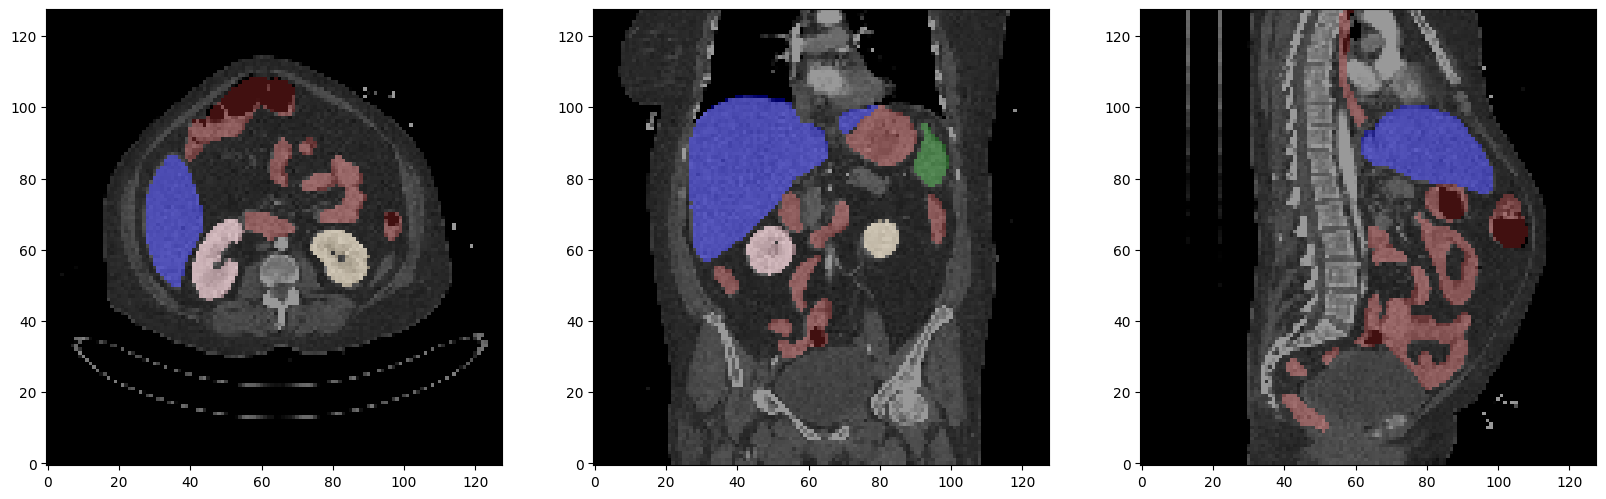

In [9]:
from matplotlib.colors import ListedColormap
label_dict = {
    0: 'background',
    1: 'liver',
    2: 'spleen',
    3: 'left kidney',
    4: 'right kidney',
    5: 'bowel'
}

color_dict = {
    0: 'black',
    1: 'blue',
    2: 'green',
    3: 'wheat',
    4: 'pink',
    5: 'brown'
}

cm = ListedColormap(color_dict.values())
def visualize(image,mask,alpha=0.4):
    image=image[:,::-1,:]
    mask=mask[:,::-1,:]
    slice1=image.shape[2]//2
    fig,ax=plt.subplots(1,3)
  
    ax[0].imshow(image[:,:,slice1].T,cmap="gray",origin="lower")
    ax[0].imshow(mask[:,:,slice1].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')

    slice2=image.shape[1]//2
    ax[1].imshow(image[:,slice2,:].T,cmap="gray",origin="lower")
    ax[1].imshow(mask[:,slice2,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')

    slice3=image.shape[0]//2
    ax[2].imshow(image[slice3,:,:].T,cmap="gray",origin="lower")
    ax[2].imshow(mask[slice3,:,:].T,alpha=alpha,origin="lower",cmap=cm,interpolation='nearest')
visualize(image,mask)

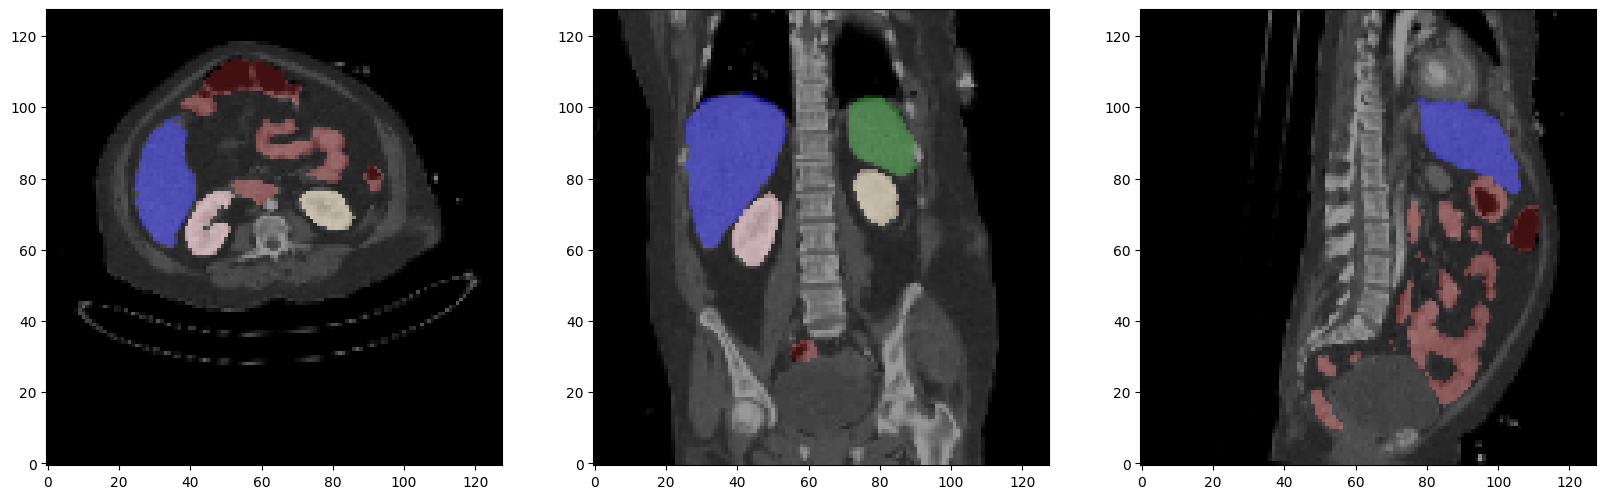

In [10]:
res = transforms_train({'image': np.expand_dims(image, 0).repeat(3, 0), 'mask':mask[None,...]})
im,ma=res["image"],res["mask"]
ma=ma.squeeze().to(torch.int)
im=im[0,...]
im=im.numpy(force=True)
ma=ma.numpy(force=True)
visualize(im,ma)


In [11]:
preprocessed1_dir="preprocessed1"
def preprocess(df):
    os.makedirs(preprocessed1_dir,exist_ok=True)
    for ind,row in df.iterrows():
        print(ind,end=" ")
        image,mask=load_image_mask(row.image_folder,row.mask_file)
        image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
        mask_file = os.path.join(preprocessed1_dir,f'{row.series_id}_mask.npy')
        np.save(image_file,image)
        np.save(mask_file,mask)
#preprocess(df_seg)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 

/home/sronen/code/.venv/lib/python3.10/site-packages/trio/_core/_multierror.py:406: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means exception groups will not show full tracebacks.
  warnings.warn(


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/user/1000/ipykernel_35362/3400977415.py:5 in <module>                                │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/user/1000/ipykernel_35362/3400977415.py'       │
│                                                                                           │
│ /tmp/user/1000/ipykernel_35362/604491282.py:55 in load_image_mask                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/user/1000/ipykernel_35362/604491282.py'        │
│                                                                                           │
│ /home/sronen/code/.venv/lib/python3.10/site-packages/monai/transforms/spatial/array.py:83 │
│ 7 in __call__                                                                             │
│                                                                                           │
│    834 │   │   _align_corners = self.align_corners if align_corners is None else align_co │
│    835 │   │   _dtype = get_equivalent_dtype(dtype or self.dtype or img.dtype, torch.Tens │
│    836 │   │   lazy_ = self.lazy if lazy is None else lazy                                │
│ ❱  837 │   │   return resize(  # type: ignore                                             │
│    838 │   │   │   img,                                                                   │
│    839 │   │   │   sp_size,                                                               │
│    840 │   │   │   _mode,                                                                 │
│                                                                                           │
│ /home/sronen/code/.venv/lib/python3.10/site-packages/monai/transforms/spatial/functional. │
│ py:295 in resize                                                                          │
│                                                                                           │
│   292 │   │   lazy: a flag that indicates whether the operation should be performed lazil │
│   293 │   │   transform_info: a dictionary with the relevant information pertaining to an │
│   294 │   """                                                                             │
│ ❱ 295 │   img = convert_to_tensor(img, track_meta=get_track_meta())                       │
│   296 │   orig_size = img.peek_pending_shape() if isinstance(img, MetaTensor) else img.sh │
│   297 │   extra_info = {                                                                  │
│   298 │   │   "mode": mode,                                                               │
│                                                                                           │
│ /home/sronen/code/.venv/lib/python3.10/site-packages/monai/utils/type_conversion.py:160   │
│ in convert_to_tensor                                                                      │
│                                                                                           │
│   157 │   │   │   # numpy array with 0 dims is also sequence iterable,                    │
│   158 │   │   │   # `ascontiguousarray` will add 1 dim if img has no dim, so we only appl │
│   159 │   │   │   if data.ndim > 0:                                                       │
│ ❱ 160 │   │   │   │   data = np.ascontiguousarray(data)                                   │
│   161 │   │   │   return _convert_tensor(data, dtype=dtype, device=device)                │
│   162 │   elif (has_cp and isinstance(data, cp_ndarray)) or isinstance(data, (float, int, │
│   163 │   │   return _convert_tensor(data, dtype=dtype, device=device)                    │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [12]:

class SEGDataset(Dataset):
    def __init__(self, df, mode, transform,use_preprocessed=True):

        self.df = df
        self.mode = mode
        self.transform = transform
        self.use_preprocessed=use_preprocessed

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        
        if self.use_preprocessed:
            image_file = os.path.join(preprocessed1_dir, f'{row.series_id}.npy')
            mask_file = os.path.join(preprocessed1_dir, f'{row.series_id}_mask.npy')
            image = np.load(image_file)
            mask = np.load(mask_file).astype(np.uint8)
        else:
            image, mask = load_sample(row, has_mask=True)


        res = self.transform({'image':image[None,...], 'mask':mask[None,...]})   
        image = res['image'] / 255.
        mask = res['mask'].squeeze().to(torch.int)

        return image, mask

In [13]:
rcParams['figure.figsize'] = 20,8

dataset_show = SEGDataset(df_seg, 'train', transform=transforms_train)


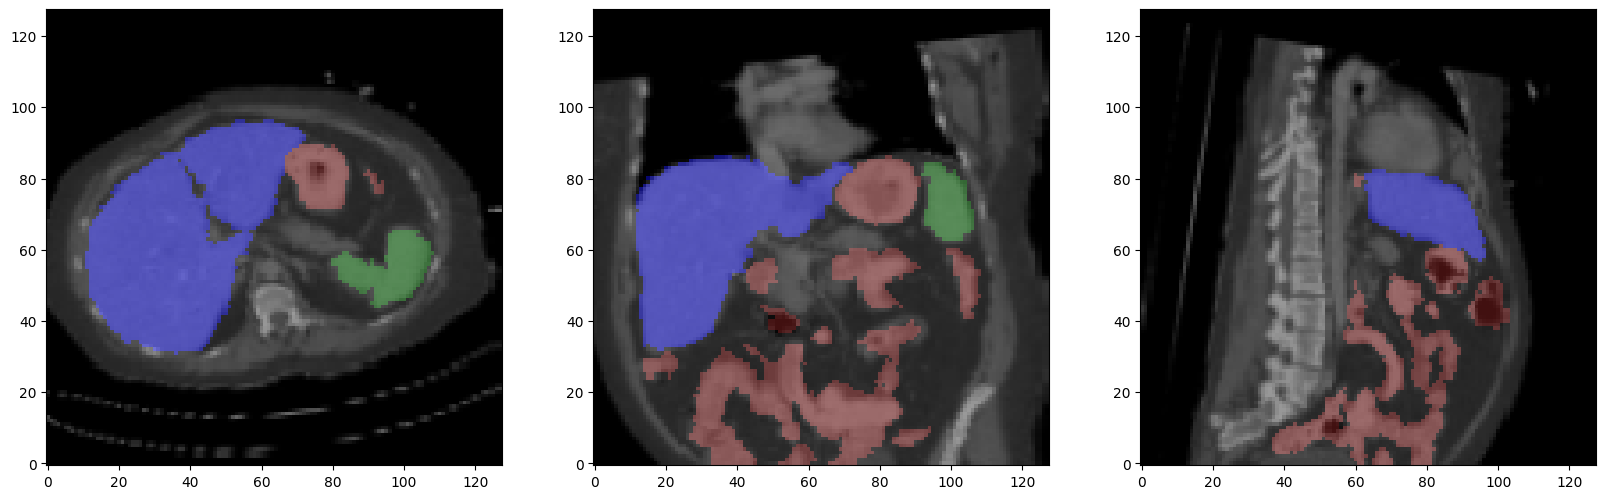

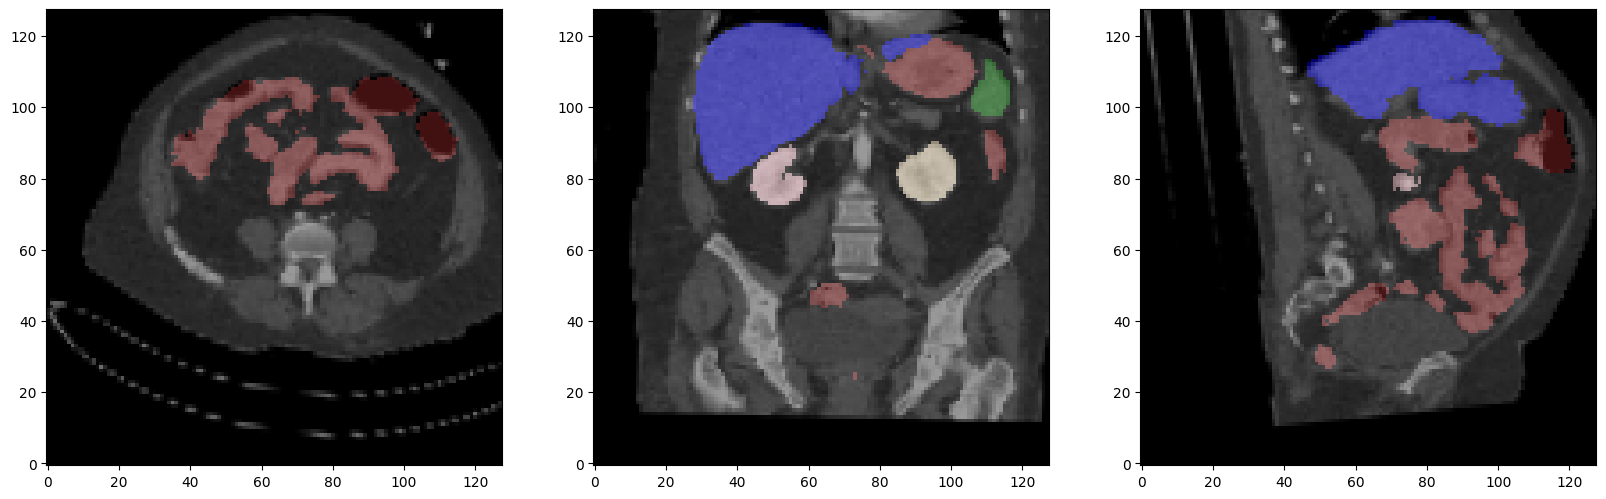

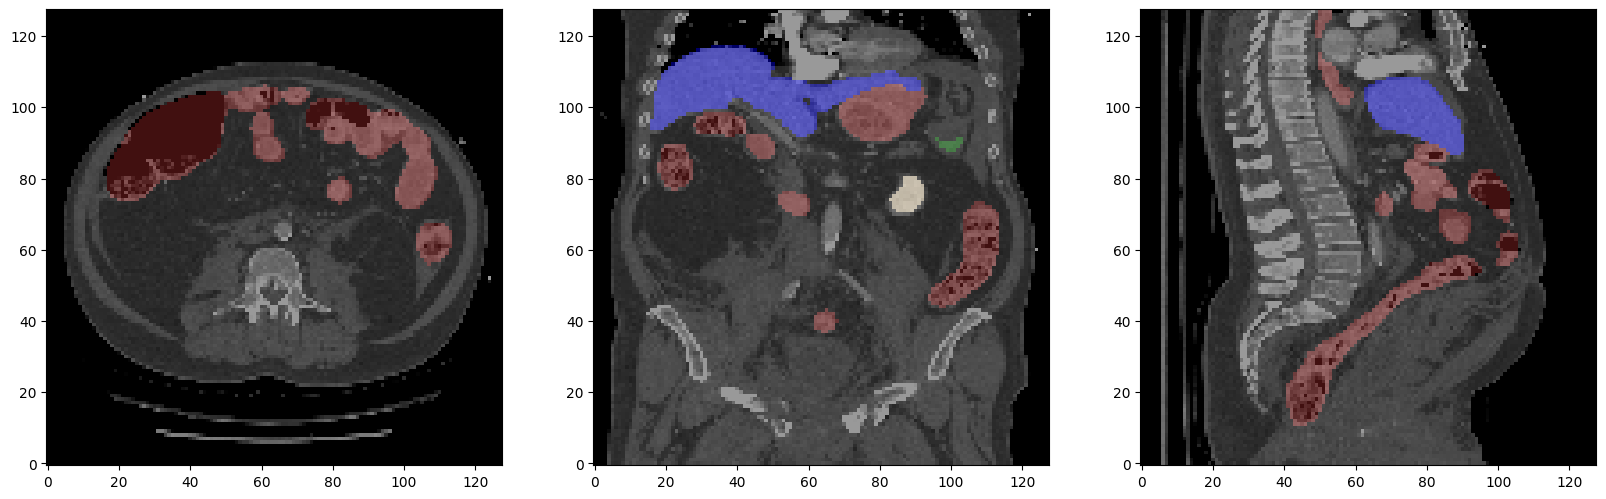

In [15]:
for i in range(3):
    img, mask = dataset_show[i]
    img=img[0,...]
    img=img.numpy(force=True)
    mask=mask.numpy(force=True)
    visualize(img,mask)

# Model

In [16]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone='reshet18d', segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=1,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        n_blocks=4
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.n_blocks=n_blocks

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:self.n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [ ]:
from timm.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output


m = TimmSegModel()
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape

# Loss & Metric

In [ ]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

# Train & Valid func

In [ ]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)


In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [ ]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:
run(0)
run(1)
run(2)
run(3)
run(4)